In [ ]:
!pip install pyswarms

     |████████████████████████████████| 102kB 5.4MB/s 


In [ ]:
import pyswarms as ps

import numpy as np
import matplotlib.pyplot as plt
import random
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

import time

from scipy.integrate import odeint,simps

In [ ]:
Cva=0.0824 #kmol/m3
Cbv=1.5324 #kmol/m3
Ccv=0 #kmol/m3
q=0.0720 #m3/min
qc=0.6307  #m3/min
ro=974.19 #kg/m3
roc=998 #kg/m3
Cp=3.7187 #kJ/(kg*K)
Cpc=4.182#kJ/(kg*K)
V=2.407 #m3
Vc=2 #m3
A=8.695 #m2
alpha=13.8 #kJ/(min*m2*K)
Tv=299.05 #K
Tvc=288.15 #K
g=10183 #K
DrH=-5.46e6 #kJ/kmol
kinf=2.8233e11 #min-1

#Inicialmente....
Ca=Cva
T=Tv
Tc=Tvc
#Leitura dos dados
data=pd.read_csv('Dados_gerados_case_geral_t_2_v2', sep='\t', encoding='utf-8',header=None)

data.columns=['Tvc_','T_','Tvc_t-1','T_t-1','Tvc_t-2','T_t-2']

#data=data.drop(['qc_','Tv_','Tvc_','q_'],axis=1)

data=data.dropna()

#---------------------------------------------------------------------------------------


#Definição de targets

#target_tc=data.pop('Tc_')
#target_ca=data.pop('Ca_')
target=data.pop('T_')
_=data.pop('Tvc_')
#Padronização dos dados
scaler=StandardScaler()

entrada=scaler.fit_transform(data)

2020-12-17 10:28:05,854 - numexpr.utils - INFO - NumExpr defaulting to 2 threads.


In [ ]:
model = tf.keras.models.load_model('Treino_RNN_v2.h5')

In [60]:



def J(u):   
    """
    u=Tvc[t-1,t,t+1]
    model = rede neural treinada
    h_pred = horizonte de predição
    h_contr = horizonte de controle
    SP = Set-point
    """
    global model,h_pred,SP,Tvc_t_1,T_t_1,Tvc_t_2,T_t_2,T_t_1_,T_,Tvc_t_2_,T_t_2_,T_t_1_
    #Parâmetro referente ao controlador (verificar artigos)
    wT=1
    lambda_q=10

#    start_time = time.time()
#    Loop para cálculo do horizonte de predição
    
    #Informação do Tvc para ser utilizado no df 'd_Tvc'
    Tvc_t_2_=Tvc_t_2
    
    T_t_2_=T_t_2
    T_t_1_=T_t_1
    
    T_=[]
    
    for i in range(h_pred):
        
        if i<3:
          
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[i],
                                                                                   T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[i]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
        else:
            T_.append(float(model(np.asarray([np.ndarray.tolist(scaler.transform([[u[3],
                                                                               T_t_1_,Tvc_t_2_,T_t_2_]]))]),training=False)))
            Tvc_t_2_=u[3]
            
            T_t_2_=T_t_1_
            T_t_1_=T_[i]
            
#    print("--- %s seconds ---" % (time.time() - start_time))
   
    #Array com os set points no decorrer da predição
    y_ref=[SP]*h_pred
    
    #Horizonte de controle (3)
    d_Tvc=[]
    d_Tvc.append((u[0]-Tvc_t_2_)**2)
    d_Tvc.append((u[1]-u[0])**2)
    d_Tvc.append((u[2]-u[1])**2)
    d_Tvc.append((u[3]-u[2])**2)
    
       
    #função objetivo
    obj=wT*sum((pd.Series(y_ref)-pd.Series(T_))**2)+lambda_q*sum(pd.Series(d_Tvc))
    
    return obj

#EDO do sistema (cstr)
def plant(z,t):
    global q,Cva,V,kinf,g,Tv,alpha,A,ro,Cp,DrH,qc,Tvc,Vc,roc,Cpc
    Ca  = z[0]
    T   = z[1]
    Tc  = z[2]
    
    dCadt=(q*(Cva-Ca)/V)-(kinf*np.exp(-g/T)*Ca)
    dTdt=((Tv-T)*q/V) -(alpha*A*(T-Tc)/(V*ro*Cp))+(kinf*np.exp(-g/T)*Ca*(-DrH)/(ro*Cp))
    dTcdt=(qc*(Tvc-Tc)/Vc)+(alpha*A*(T-Tc)/(Vc*roc*Cpc))
    dzdt = [dCadt,dTdt,dTcdt]
    
    return dzdt


In [61]:

#FO
qc_t_1=0.6307
Tv_t_1=299.05
Tvc_t_1=288.15
q_t_1=0.072
T_t_1=296.7227
qc_t_2=0.6307
Tv_t_2=299.05
Tvc_t_2=288.15
q_t_2=0.072
T_t_2=296.7227

#Condições iniciais da EDO (partindo do estado estacionário)
Ca=0.0814416
T=296.7227
Tc=288.5237
Tvc=288.15

Tv=299.05 #K
#---------------------
#Entradas - Horizonte de predição e Set-point
h_pred=8
SP=298

z_=[]
z0 = [Ca,T,Tc]
Tvc_=[]
sp_=[]

u=[288.15,288.15,288.15,288.15]
					
def min_f(particles):
        return [J(particle) for particle in particles]
    
    
constraints = (np.array([275,275,275,275]),
               np.array([310,310,310,310]))

In [62]:
start_time = time.time()
final_step=50
for i in range(final_step):
     
    if i==25:
        SP=297
    
    options={'c1':2,'c2':2,'w':0.5}
    optimizer=ps.single.GlobalBestPSO(n_particles=50,dimensions=4,options=options,bounds=constraints)
    popt=optimizer.optimize(min_f,iters=50)
    
    
    Tvc=popt[1][0]
    Tvc_.append(Tvc)
    #Intervalos de tempo para a integração
    t = np.linspace(0,1,2)
    
    z_.append(np.ndarray.tolist(odeint(plant,z0,t)[1]))
    
    z0=z_[-1]
    
#    Atualização do valor para a próxima iteração
    Tvc_t_2=Tvc_t_1
    Tvc_t_1=Tvc

    
    T_t_2=T_t_1
    T_t_1=z0[1]
    
    u=popt[1]
    
    print(z_)
    print('\n')
    print(T_)
    
    print('\n %.1f %%'%(i*100/final_step))
    print(70*'=')
    
    sp_.append(SP)
    
print("--- %s seconds ---" % (time.time() - start_time))

2020-12-17 18:42:39,016 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=6.68
2020-12-17 18:43:49,709 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.675354898720771, best pos: [298.96080733 298.92807371 298.95392521 298.98159117]
2020-12-17 18:43:49,717 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408]]


[296.7695007324219, 296.8466491699219, 296.9446105957031, 297.0545349121094, 297.17071533203125, 297.2882080078125, 297.40325927734375, 297.51312255859375]

 0.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=6.06
2020-12-17 18:44:59,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.058270671846758, best pos: [293.16039823 293.1564052  293.16165646 293.15983367]
2020-12-17 18:44:59,422 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975]]


[296.802978515625, 296.8883972167969, 296.991455078125, 297.1031799316406, 297.2189636230469, 297.33441162109375, 297.44622802734375, 297.55206298828125]

 2.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.39
2020-12-17 18:46:09,925 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.388639946909299, best pos: [295.05918366 295.06251812 294.9954626  294.97330778]
2020-12-17 18:46:09,935 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745]]


[296.85650634765625, 296.94964599609375, 297.0539245605469, 297.1678771972656, 297.28363037109375, 297.3973693847656, 297.50628662109375, 297.6083984375]

 4.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=19.1
2020-12-17 18:47:20,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 19.12824734734837, best pos: [276.64359635 276.27295157 275.8075104  275.62348235]
2020-12-17 18:47:20,843 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374]]


[296.9068603515625, 296.9990539550781, 297.1059875488281, 297.2171630859375, 297.3289794921875, 297.43798828125, 297.54168701171875, 297.6383972167969]

 6.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=4.88
2020-12-17 18:48:31,461 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.8837886255203315, best pos: [295.73140368 295.7249317  295.72999083 295.73278972]
2020-12-17 18:48:31,470 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628]]


[296.91607666015625, 296.99615478515625, 297.09197998046875, 297.19586181640625, 297.30322265625, 297.4100341796875, 297.5133361816406, 297.6109924316406]

 8.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=26
2020-12-17 18:49:41,106 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 26.0177432355999, best pos: [277.38323916 278.44226147 278.12626773 278.29783069]
2020-12-17 18:49:41,120 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715]]


[296.91998291015625, 296.9983825683594, 297.0901794433594, 297.1953430175781, 297.30413818359375, 297.4124755859375, 297.517333984375, 297.61651611328125]

 10.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.33
2020-12-17 18:50:51,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.334243749214162, best pos: [295.44471454 295.44694305 295.44938867 295.45038051]
2020-12-17 18:50:51,835 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837]]


[296.90301513671875, 296.96826171875, 297.0531005859375, 297.15020751953125, 297.25372314453125, 297.3590393066406, 297.462646484375, 297.5619201660156]

 12.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.36
2020-12-17 18:52:02,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.358082749544366, best pos: [294.61162228 294.61896755 294.61415848 294.61095759]
2020-12-17 18:52:02,853 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136]]


[296.8976745605469, 296.9647521972656, 297.0510559082031, 297.1492919921875, 297.2536315917969, 297.3595275878906, 297.4635009765625, 297.56298828125]

 14.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=4.75
2020-12-17 18:53:14,069 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.753541071827631, best pos: [300.76616007 300.76460393 300.76518604 300.75678698]
2020-12-17 18:53:14,078 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594]]


[296.930908203125, 297.0087890625, 297.1023864746094, 297.2049560546875, 297.3113098144531, 297.41741943359375, 297.520263671875, 297.61761474609375]

 16.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=3.9
2020-12-17 18:54:23,777 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.8980123769637784, best pos: [296.25295135 296.2507965  296.24593601 296.24958087]
2020-12-17 18:54:23,793 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628]]


[296.9955749511719, 297.0851135253906, 297.18487548828125, 297.2894592285156, 297.3946228027344, 297.49713134765625, 297.5946350097656, 297.685546875]

 18.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=3.11
2020-12-17 18:55:32,775 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.114326214992078, best pos: [293.93226821 293.93524987 293.93381389 293.9342579 ]
2020-12-17 18:55:32,784 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304]]


[297.0729675292969, 297.16558837890625, 297.267333984375, 297.3708801269531, 297.47271728515625, 297.5703125, 297.661865234375, 297.7461853027344]

 20.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.61
2020-12-17 18:56:42,539 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.6058743650014065, best pos: [291.84829124 291.85961283 291.85994784 291.83913594]
2020-12-17 18:56:42,547 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984]]


[297.1415100097656, 297.23443603515625, 297.3322448730469, 297.43072509765625, 297.5268859863281, 297.6184997558594, 297.7040100097656, 297.7824401855469]

 22.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=2.35
2020-12-17 18:57:53,053 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 2.3486531713952, best pos: [284.58582847 284.58660474 284.58110254 284.58333001]
2020-12-17 18:57:53,065 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075]]


[297.19256591796875, 297.2762756347656, 297.36541748046875, 297.4559631347656, 297.5449523925781, 297.63018798828125, 297.7101135253906, 297.78369140625]

 24.0 %


pyswarms.single.global_best: 100%|██████████|50/50, best_cost=14.9
2020-12-17 18:59:03,087 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 14.928616388450628, best pos: [308.87737091 308.49878599 309.20682096 308.50537115]
2020-12-17 18:59:03,096 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586]]


[297.21905517578125, 297.2917175292969, 297.36651611328125, 297.4568176269531, 297.54693603515625, 297.6343078613281, 297.717041015625, 29

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=4.32
2020-12-17 19:00:13,731 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 4.323649835883053, best pos: [306.63010333 306.71639124 306.4116962  306.25273539]
2020-12-17 19:00:13,746 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044]]


[297.2876892089844, 297.36199951171875, 297.44183349609375, 297.5293273925781

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.903
2020-12-17 19:01:24,843 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.903292688183929, best pos: [297.90909962 297.90964188 297.91135615 297.91079468]
2020-12-17 19:01:24,854 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218]]


[297.41586303710

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.473
2020-12-17 19:02:36,100 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.47254845734774764, best pos: [297.64879688 297.65019168 297.65192989 297.65195643]
2020-12-17 19:02:36,110 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.297
2020-12-17 19:03:47,690 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2972184561006996, best pos: [280.43405733 280.44134842 280.45456995 280.46487007]
2020-12-17 19:03:47,704 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.251
2020-12-17 19:04:58,715 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.25086726565296846, best pos: [291.22054265 291.220119   291.21746679 291.21906218]
2020-12-17 19:04:58,730 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.274
2020-12-17 19:06:10,131 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.274348117558661, best pos: [296.63812339 296.63856723 296.63315751 296.63507085]
2020-12-17 19:06:10,139 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.244
2020-12-17 19:07:20,314 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.24381838088256488, best pos: [284.45633218 284.45062652 284.45177587 284.45902721]
2020-12-17 19:07:20,327 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.271
2020-12-17 19:08:30,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.27070627962298205, best pos: [282.59487483 282.58999523 282.61412562 282.59582852]
2020-12-17 19:08:30,342 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.407
2020-12-17 19:09:40,958 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.4072618404147649, best pos: [286.82596557 286.82549582 286.82659912 286.82584623]
2020-12-17 19:09:40,970 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.539
2020-12-17 19:10:51,300 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.5387180247409453, best pos: [300.64066576 300.6390331  300.63970123 300.63738829]
2020-12-17 19:10:51,312 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=0.56
2020-12-17 19:12:02,165 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.559725988425768, best pos: [303.98512153 304.05788552 303.99851144 303.95162289]
2020-12-17 19:12:02,176 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=5.97
2020-12-17 19:13:14,376 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 5.971575098423379, best pos: [288.55295744 288.55445764 288.55609577 288.55933615]
2020-12-17 19:13:14,388 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=6.77
2020-12-17 19:14:26,158 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 6.7655014810135805, best pos: [300.38705156 300.38956831 300.39099026 300.38989657]
2020-12-17 19:14:26,168 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.28
2020-12-17 19:15:37,457 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.281450665503782, best pos: [293.1512937  293.14405338 293.14517727 293.14853384]
2020-12-17 19:15:37,471 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.66
2020-12-17 19:16:48,656 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.655920153549247, best pos: [283.25779301 283.2669497  283.26180863 283.25082169]
2020-12-17 19:16:48,667 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.58
2020-12-17 19:18:00,224 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.580616145339893, best pos: [298.87220386 298.87244893 298.86390133 298.85873674]
2020-12-17 19:18:00,236 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.78
2020-12-17 19:19:12,123 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.778864551381395, best pos: [301.88226832 301.87137334 301.87740278 301.88002627]
2020-12-17 19:19:12,132 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=8.46
2020-12-17 19:20:24,565 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.45920862286608, best pos: [282.51497279 282.51762744 282.51976158 282.51866496]
2020-12-17 19:20:24,576 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=8.54
2020-12-17 19:21:38,143 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 8.536526960747251, best pos: [288.0107144  288.01278981 288.01499884 288.01837862]
2020-12-17 19:21:38,155 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.79
2020-12-17 19:22:51,631 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.789762640692173, best pos: [283.79437516 283.79473649 283.79481407 283.79272308]
2020-12-17 19:22:51,643 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.2
2020-12-17 19:24:05,390 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.204211687461281, best pos: [297.19459469 297.19220405 297.19588649 297.18876183]
2020-12-17 19:24:05,403 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.17
2020-12-17 19:25:20,524 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.1725986455132, best pos: [296.9122966  296.90785654 296.91516105 296.9109825 ]
2020-12-17 19:25:20,534 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.57
2020-12-17 19:26:33,576 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.5680876416790275, best pos: [286.58011596 286.5802147  286.57845004 286.5781035 ]
2020-12-17 19:26:33,585 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.68
2020-12-17 19:27:46,156 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.678565123675041, best pos: [292.35102172 292.35111803 292.34502663 292.34372333]
2020-12-17 19:27:46,165 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.88
2020-12-17 19:28:58,861 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.8841827377108595, best pos: [307.63387433 307.66125956 307.68090363 307.66275446]
2020-12-17 19:28:58,871 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=9.66
2020-12-17 19:30:10,669 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.65892658762799, best pos: [298.65203122 298.73953436 298.85383355 298.88544923]
2020-12-17 19:30:10,683 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=10.3
2020-12-17 19:31:23,175 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.25908629959852, best pos: [291.74029771 291.74523659 291.74312496 291.74010588]
2020-12-17 19:31:23,186 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=10.7
2020-12-17 19:32:34,826 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.7409496987017, best pos: [286.04436517 286.04174026 286.03950859 286.04418216]
2020-12-17 19:32:34,838 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=10.3
2020-12-17 19:33:45,995 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.273178100232524, best pos: [281.21262353 281.16745378 281.13799353 281.21850877]
2020-12-17 19:33:46,004 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=9.31
2020-12-17 19:34:57,238 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.313810047331572, best pos: [298.23468742 298.22675106 298.23089734 298.24025783]
2020-12-17 19:34:57,248 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=9.05
2020-12-17 19:36:08,303 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.053447143559225, best pos: [295.2454261  295.24989903 295.23979288 295.23823924]
2020-12-17 19:36:08,314 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=9.57
2020-12-17 19:37:19,991 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.567050646451944, best pos: [295.75749171 295.75208809 295.75744731 295.75922468]
2020-12-17 19:37:20,005 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=9.86
2020-12-17 19:38:30,412 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 9.861684008378814, best pos: [282.79017713 282.79445204 282.79918257 282.7948099 ]
2020-12-17 19:38:30,422 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=10.5
2020-12-17 19:39:40,757 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 10.51588328239578, best pos: [280.36246977 280.64461943 280.6460553  280.48909716]
2020-12-17 19:39:40,771 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.97
2020-12-17 19:40:51,607 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.972140673988124, best pos: [281.94114413 281.93491927 281.94130847 281.95704837]
2020-12-17 19:40:51,616 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 2, 'c2': 2, 'w': 0.5}
pyswarms.single.global_best:   0%|          |0/50

[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

pyswarms.single.global_best: 100%|██████████|50/50, best_cost=7.1
2020-12-17 19:42:01,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 7.103078425584215, best pos: [303.02917731 303.08346201 303.126276   303.03830905]


[[0.0814415778427068, 296.7435000566548, 291.4279435472408], [0.08144144386368525, 296.78571204568306, 291.95869095107975], [0.0814411628349438, 296.8360776435151, 292.8510052435745], [0.08144074938875248, 296.85935416102143, 288.5461720862374], [0.08144031796329916, 296.86903061890877, 290.5781917495628], [0.08143986710986723, 296.8663773437973, 287.1106586085715], [0.08143946896322221, 296.85874672206575, 289.46883816459837], [0.08143906140274455, 296.8768894099873, 290.9409456004136], [0.081438563231476, 296.9230992798174, 293.6532703080594], [0.08143788304120299, 296.99003729750405, 294.3920915279628], [0.08143699232744113, 297.0584719683751, 294.30082883544304], [0.0814359074354186, 297.11926929509525, 293.67617319031984], [0.08143468121326221, 297.156626576284, 291.2766471883075], [0.08143336104021258, 297.2117567722382, 296.07707420942586], [0.0814317974201208, 297.31563780381055, 298.9264937250044], [0.08142988476141792, 297.4315720366989, 298.6342240781218], [0.081427635060256

In [63]:
import matplotlib.pyplot as plt


In [68]:
"""
Plotagem dos resultados
"""
p_=pd.DataFrame(z_)

SAVE_RESULTS=p_.copy()
SAVE_RESULTS['sp']=sp_
SAVE_RESULTS['Tvc']=Tvc_


SAVE_RESULTS.to_csv('Result_RNN_V6.csv', sep='\t', encoding='utf-8', header=None, index=False)



In [69]:
#Métricas de erro
IAE=simps(abs(sp_-p_[1]))
ISE=simps((sp_-p_[1])**2)
ITAE=simps(np.linspace(0,final_step-1,final_step)*abs(sp_-p_[1]))
ITSE=simps(np.linspace(0,final_step-1,final_step)*((sp_-p_[1])**2))

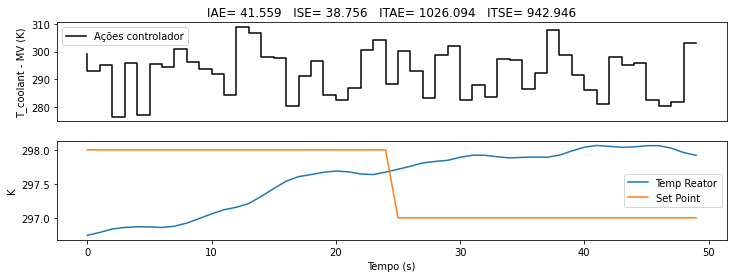

In [70]:


#Plotagem
plt.figure(figsize=(12,4))
plt.subplot(2,1,1)
plt.title("IAE= "+'%.3f'%IAE+ "   ISE= "+'%.3f'%ISE+"   ITAE= "+'%.3f'%ITAE+"   ITSE= "+'%.3f'%ITSE)
plt.step(np.linspace(0,final_step-1,final_step),Tvc_,'k',label='Ações controlador')
plt.ylabel('T_coolant - MV (K)')
#plt.xlabel('Tempo (s)')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.legend()


#plt.figure(figsize=(12,4))
plt.subplot(2,1,2)
plt.plot(p_[1],label='Temp Reator')
plt.plot(sp_,label='Set Point')
plt.ylabel('K')
plt.xlabel('Tempo (s)')

plt.xticks(np.linspace(0,final_step,6))
plt.legend()

plt.show()

